In [1]:
import neural_net_class as NNC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import  train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# --- defining the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise

X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

In [4]:
# Define layer sizes and activations
layer_output_sizes = [50, 1]
activations = [NNC.sigmoid, NNC.identity_func]

# Initialize and train the network
nn = NNC.NeuralNet(X_train, z_train, layer_output_sizes, activations, loss_fn='mse', epsilon=0.001, batch_size=100, epochs=100)
nn.train_network()

# Make predictions
pred_train = nn.predict_probabilities(X_train)
pred_test = nn.predict_probabilities(X_test)

# Evaluate accuracy
print(f'Train accuracy: {mean_squared_error(z_train, pred_train)}')
print(f'Test accuracy: {mean_squared_error(z_test, pred_test)}')

Train accuracy: 0.07887336614199449
Test accuracy: 0.07525960472115571


### Plotting the prediction and the data

In [5]:
z_total = nn.predict_probabilities(X)
# total_loss = model.evaluate(X, z)
# print(f'Total loss: {total_loss}')

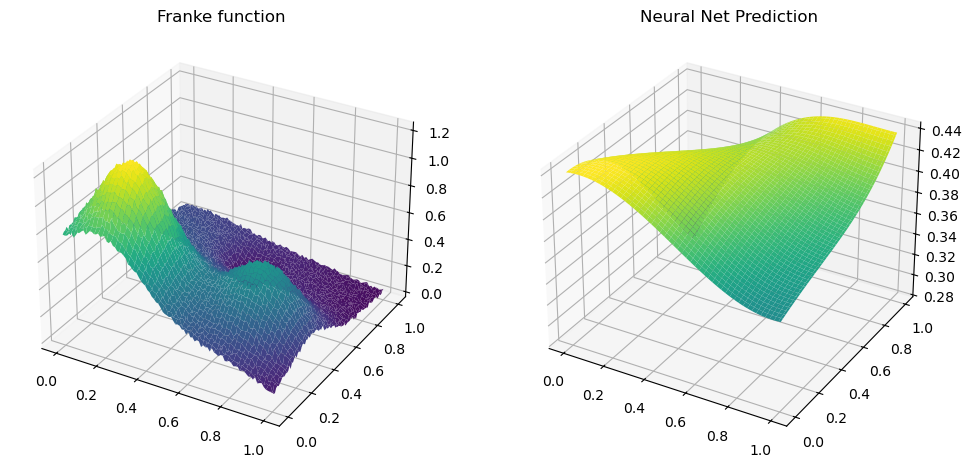

In [6]:
# REshaping for plotting
x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))
z_orig_plot = z.reshape((n,n))

fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke function')
#ax.view_init(azim=230)

# Plot the polynomial regression prediction 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Neural Net Prediction')
#ax.view_init(azim=230)

plt.show()